In [31]:
import numpy as np # linear algebra
import pandas as pd
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# import data

In [32]:
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
sample_sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')


print('sales:', sales.shape, 'items:', items.shape, 'item_cats:', item_cat.shape, 'shops:', shops.shape, 'sample submission', sample_sub.shape)

sales: (2935849, 6) items: (22170, 3) item_cats: (84, 2) shops: (60, 2) sample submission (214200, 2)


In [33]:
sales['date'] = pd.to_datetime(sales['date'])
print(sales.info())
sales.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


# cleaning

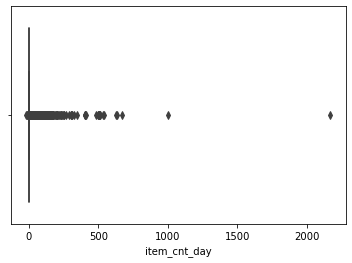

In [34]:
# looking for outliers
sns.boxplot(x=sales.item_cnt_day)

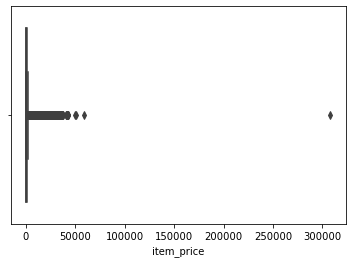

In [35]:
sns.boxplot(x=sales.item_price)

In [36]:
# remove it
sales = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
sales = sales[(sales.item_cnt_day < 1001) & (sales.item_cnt_day > 0)]

In [37]:
# get shops ID and item ID
test_shops = test.shop_id.unique()
sales = sales[sales.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = sales[sales.item_id.isin(test_items)]

## Exploring monthly sales

In [38]:
# aggregation for the monthly sales
total_sales = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
total_sales.head(20)

date_block_num
0      92193.0
1      90716.0
2     114905.0
3      84189.0
4      85763.0
5     103566.0
6      94986.0
7     101691.0
8     107569.0
9      98640.0
10    105871.0
11    149596.0
12     93532.0
13     89569.0
14     93257.0
15     77525.0
16     78795.0
17     79062.0
18     74499.0
19     84010.0
Name: item_cnt_day, dtype: float64

### EDA

In [39]:
fig = px.line(total_sales, labels={
    'date_block_num': "Month",
    'value': "Sales"
    })
fig.show()

In [40]:
res = sm.tsa.seasonal_decompose(total_sales.values, period=12)

In [41]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=res.seasonal,
                    mode='lines',
                    name='seasonal'))
fig.add_trace(go.Scatter(y=res.trend,
                    mode='lines',
                    name='trend'),
                    secondary_y=True)
fig.add_trace(go.Scatter(y=res.resid,
                    mode='lines',
                    name='residual'))
fig.add_trace(go.Scatter(y=res.observed,
                    mode='lines',
                    name='observed'),
                    secondary_y=True)
fig.update_layout(title={
                    'text': "Original"
})

fig.show()

adf = sm.tsa.stattools.adfuller(total_sales)
print('Dickey-Fuller results:', adf[1:])

Dickey-Fuller results: (0.03672151506664592, 0, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, 521.2367324478362)


In [42]:
total_sales_no_trend = total_sales - total_sales.shift(1)

res = sm.tsa.seasonal_decompose(total_sales_no_trend[1:], period=12)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=res.trend,
                    mode='lines',
                    name='trend'),
                    secondary_y=True)
fig.add_trace(go.Scatter(y=res.observed,
                    mode='lines',
                    name='observed'),
                    secondary_y=True)
fig.add_trace(go.Scatter(y=res.seasonal,
                    mode='lines',
                    name='seasonal'))
fig.update_layout(title={
                    'text': "After removing the trend"
                    })

fig.show()

adf = sm.tsa.stattools.adfuller(total_sales_no_trend[1:])
print('Dickey-Fuller results:', adf[1:])

Dickey-Fuller results: (1.0399354557949493e-26, 10, 22, {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}, 450.36681639304845)


# Using prophet for forcast on the overall sales

In [43]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()
ts.columns=['ds','y']

In [44]:
# build model
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

           ds           yhat     yhat_lower     yhat_upper
34 2015-11-01   81663.611890   78208.699170   84843.820662
35 2015-12-01  117099.561581  113939.088642  120525.073839
36 2016-01-01   80720.618083   77489.159300   83971.212287
37 2016-02-01   54608.743157   51480.052987   57964.915408
38 2016-03-01   86884.189410   83848.147787   90254.612159


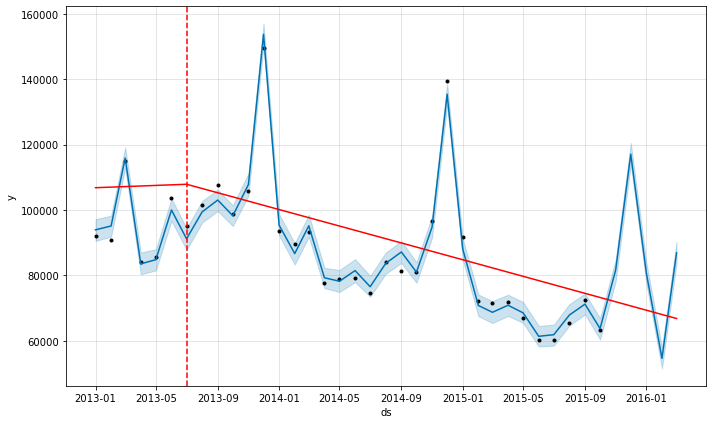

In [45]:
# make forecast
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

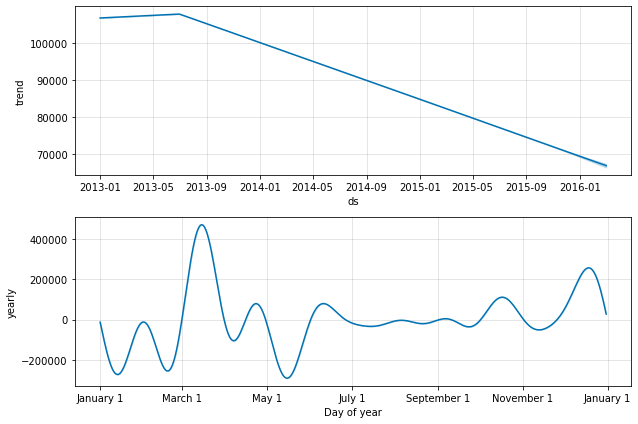

In [46]:
fig = model.plot_components(forecast)

# Competition predictions with LGBM

In [47]:
test.insert(loc=3, column='date_block_num', value=34)
# test = pd.merge(test, shops, on=['shop_id'], how='left')
test = pd.merge(test, items, on=['item_id'], how='left')
test['date_block_num'] = 34

test = test.drop(['item_name', 'ID'], axis=1)
print(f'Shape of test data: {test.shape}')
test.head(5)

Shape of test data: (214200, 4)


,shop_id,item_id,date_block_num,item_category_id
0,5,5037,34,19
1,5,5320,34,55
2,5,5233,34,19
3,5,5232,34,23
4,5,5268,34,20


In [48]:
# merge with shops and items
train = pd.merge(sales, shops, on=['shop_id'], how='left')
train = pd.merge(train, items, on=['item_id'], how='left')
train = pd.merge(train, item_cat, on=['item_category_id'], how='left')
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'item_category_id'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
train['item_cnt_month'] = (train['item_cnt_month'].fillna(0).clip(0,20))

# add test
df = pd.concat([train, test], ignore_index=True, sort=False, keys=['shop_id', 'item_id', 'date_block_num'])
df.fillna(0, inplace=True)

print(f'Shape of training data: {df.shape}')

Shape of training data: (1537229, 5)


In [49]:
def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

df = generate_lag(df, [1, 2, 3], 'item_cnt_month')
df.fillna(0, inplace=True)

In [50]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [51]:
X_train.head(5)

,shop_id,item_id,date_block_num,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,2,27,0,19,0.0,0.0,0.0
1,2,27,17,19,0.0,0.0,0.0
2,2,30,2,40,0.0,0.0,0.0
3,2,30,5,40,0.0,0.0,1.0
4,2,30,15,40,0.0,0.0,0.0


In [62]:
import lightgbm as lgb
import optuna
import sklearn.metrics

from sklearn.metrics import mean_squared_error as rmse

feature_name = X_train.columns.tolist()

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

In [63]:
def objective(trial):
        
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'learning_rate':0.001,
        "num_leaves": trial.suggest_int("num_leaves", 50, 150),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=15,
                      verbose_eval=1)
    
    y_pred = model.predict(X_valid)
    accuracy = rmse(Y_valid, y_pred)

    return accuracy

In [64]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2020-10-13 15:09:09,175] A new study created in memory with name: no-name-01dff061-b417-4dea-bfb4-6448b096f666


[1]	training's rmse: 2.46804	valid_1's rmse: 2.24548
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 2.38924	valid_1's rmse: 2.16903
[3]	training's rmse: 2.32405	valid_1's rmse: 2.11526
[4]	training's rmse: 2.26845	valid_1's rmse: 2.06421
[5]	training's rmse: 2.22085	valid_1's rmse: 2.02403
[6]	training's rmse: 2.1806	valid_1's rmse: 1.98304
[7]	training's rmse: 2.14706	valid_1's rmse: 1.94791
[8]	training's rmse: 2.1197	valid_1's rmse: 1.92522
[9]	training's rmse: 2.09492	valid_1's rmse: 1.90255
[10]	training's rmse: 2.07559	valid_1's rmse: 1.88832
[11]	training's rmse: 2.05786	valid_1's rmse: 1.87325
[12]	training's rmse: 2.04301	valid_1's rmse: 1.86186
[13]	training's rmse: 2.02989	valid_1's rmse: 1.85319
[14]	training's rmse: 2.01875	valid_1's rmse: 1.84607
[15]	training's rmse: 2.00838	valid_1's rmse: 1.8389
[16]	training's rmse: 1.9978	valid_1's rmse: 1.8343
[17]	training's rmse: 1.98871	valid_1's rmse: 1.83092
[18]	training's rmse: 1.98219	valid

[I 2020-10-13 15:09:16,702] Trial 0 finished with value: 3.216251184358488 and parameters: {'num_leaves': 102, 'feature_fraction': 0.9848302111130056, 'bagging_fraction': 0.6297039976135443, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 0 with value: 3.216251184358488.


[1]	training's rmse: 2.46981	valid_1's rmse: 2.2527
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 2.40979	valid_1's rmse: 2.19375
[3]	training's rmse: 2.33614	valid_1's rmse: 2.13351
[4]	training's rmse: 2.27364	valid_1's rmse: 2.07241
[5]	training's rmse: 2.22301	valid_1's rmse: 2.02981
[6]	training's rmse: 2.18138	valid_1's rmse: 1.99308
[7]	training's rmse: 2.14435	valid_1's rmse: 1.95673
[8]	training's rmse: 2.11252	valid_1's rmse: 1.92732
[9]	training's rmse: 2.08629	valid_1's rmse: 1.91098
[10]	training's rmse: 2.06512	valid_1's rmse: 1.89655
[11]	training's rmse: 2.04655	valid_1's rmse: 1.87818
[12]	training's rmse: 2.03296	valid_1's rmse: 1.86921
[13]	training's rmse: 2.01992	valid_1's rmse: 1.85933
[14]	training's rmse: 2.00997	valid_1's rmse: 1.8534
[15]	training's rmse: 1.99676	valid_1's rmse: 1.84676
[16]	training's rmse: 1.98691	valid_1's rmse: 1.84287
[17]	training's rmse: 1.97819	valid_1's rmse: 1.83791
[18]	training's rmse: 1.96977	va

[I 2020-10-13 15:09:22,920] Trial 1 finished with value: 3.248385299781423 and parameters: {'num_leaves': 127, 'feature_fraction': 0.910896801448073, 'bagging_fraction': 0.6927495425812572, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 0 with value: 3.216251184358488.


[1]	training's rmse: 2.47224	valid_1's rmse: 2.2524
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 2.39697	valid_1's rmse: 2.18574
[3]	training's rmse: 2.33487	valid_1's rmse: 2.13304
[4]	training's rmse: 2.28187	valid_1's rmse: 2.08616
[5]	training's rmse: 2.23764	valid_1's rmse: 2.04479
[6]	training's rmse: 2.20047	valid_1's rmse: 2.00602
[7]	training's rmse: 2.16936	valid_1's rmse: 1.98184
[8]	training's rmse: 2.14292	valid_1's rmse: 1.96278
[9]	training's rmse: 2.1205	valid_1's rmse: 1.94252
[10]	training's rmse: 2.10172	valid_1's rmse: 1.93016
[11]	training's rmse: 2.08547	valid_1's rmse: 1.91907
[12]	training's rmse: 2.07205	valid_1's rmse: 1.91044
[13]	training's rmse: 2.06031	valid_1's rmse: 1.90317
[14]	training's rmse: 2.05072	valid_1's rmse: 1.89703
[15]	training's rmse: 2.04153	valid_1's rmse: 1.88775
[16]	training's rmse: 2.03324	valid_1's rmse: 1.88319
[17]	training's rmse: 2.02582	valid_1's rmse: 1.87743
[18]	training's rmse: 2.02046	va

[I 2020-10-13 15:09:30,981] Trial 2 finished with value: 3.31017745830402 and parameters: {'num_leaves': 50, 'feature_fraction': 0.9709281333352551, 'bagging_fraction': 0.9992118308347704, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 0 with value: 3.216251184358488.


[1]	training's rmse: 2.47293	valid_1's rmse: 2.25833
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 2.42058	valid_1's rmse: 2.20228
[3]	training's rmse: 2.35199	valid_1's rmse: 2.14311
[4]	training's rmse: 2.29563	valid_1's rmse: 2.09071
[5]	training's rmse: 2.24863	valid_1's rmse: 2.05108
[6]	training's rmse: 2.20931	valid_1's rmse: 2.01806
[7]	training's rmse: 2.1756	valid_1's rmse: 1.98421
[8]	training's rmse: 2.14671	valid_1's rmse: 1.96485
[9]	training's rmse: 2.12355	valid_1's rmse: 1.94554
[10]	training's rmse: 2.1049	valid_1's rmse: 1.93271
[11]	training's rmse: 2.0878	valid_1's rmse: 1.9178
[12]	training's rmse: 2.07586	valid_1's rmse: 1.90926
[13]	training's rmse: 2.06428	valid_1's rmse: 1.90151
[14]	training's rmse: 2.05442	valid_1's rmse: 1.89596
[15]	training's rmse: 2.04196	valid_1's rmse: 1.88868
[16]	training's rmse: 2.03436	valid_1's rmse: 1.88355
[17]	training's rmse: 2.0263	valid_1's rmse: 1.87846
[18]	training's rmse: 2.01794	valid

[I 2020-10-13 15:09:36,892] Trial 3 finished with value: 3.3211363550990813 and parameters: {'num_leaves': 57, 'feature_fraction': 0.8584321024774284, 'bagging_fraction': 0.9188470414320141, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 0 with value: 3.216251184358488.


[1]	training's rmse: 2.46982	valid_1's rmse: 2.25303
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 2.40882	valid_1's rmse: 2.19931
[3]	training's rmse: 2.33533	valid_1's rmse: 2.14544
[4]	training's rmse: 2.27356	valid_1's rmse: 2.09659
[5]	training's rmse: 2.22144	valid_1's rmse: 2.05789
[6]	training's rmse: 2.1805	valid_1's rmse: 2.02232
[7]	training's rmse: 2.14464	valid_1's rmse: 1.98775
[8]	training's rmse: 2.11267	valid_1's rmse: 1.96026
[9]	training's rmse: 2.0879	valid_1's rmse: 1.94006
[10]	training's rmse: 2.06614	valid_1's rmse: 1.92685
[11]	training's rmse: 2.04797	valid_1's rmse: 1.91139
[12]	training's rmse: 2.03314	valid_1's rmse: 1.89883
[13]	training's rmse: 2.02082	valid_1's rmse: 1.88818
[14]	training's rmse: 2.00999	valid_1's rmse: 1.88236
[15]	training's rmse: 1.99793	valid_1's rmse: 1.87523
[16]	training's rmse: 1.98874	valid_1's rmse: 1.86928
[17]	training's rmse: 1.9805	valid_1's rmse: 1.86328
[18]	training's rmse: 1.97286	val

[I 2020-10-13 15:09:42,475] Trial 4 finished with value: 3.2895811920229874 and parameters: {'num_leaves': 143, 'feature_fraction': 0.8328025551796662, 'bagging_fraction': 0.49618895993194057, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 0 with value: 3.216251184358488.


Number of finished trials: 5
Best trial: {'num_leaves': 102, 'feature_fraction': 0.9848302111130056, 'bagging_fraction': 0.6297039976135443, 'bagging_freq': 5, 'min_child_samples': 58}


In [55]:
opt_params = study.best_trial.params
print(f'optimal trial parameters\n{opt_params}')

optimal trial parameters
{'num_leaves': 118, 'feature_fraction': 0.9944334661353047, 'bagging_fraction': 0.9381783170038966, 'bagging_freq': 6, 'min_child_samples': 77}


In [71]:
x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

opt_params.update(x)
opt_params

{'num_leaves': 118,
 'feature_fraction': 0.9944334661353047,
 'bagging_fraction': 0.9381783170038966,
 'bagging_freq': 6,
 'min_child_samples': 77,
 'objective': 'regression',
 'metric': 'rmse',
 'learning_rate': 0.001,
 'verbosity': -1,
 'boosting_type': 'gbdt'}

In [72]:
evals_result = {} 

model = lgb.train(opt_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],
                  evals_result=evals_result,
                  early_stopping_rounds=100,
                  verbose_eval=1,
                  )

[1]	training's rmse: 2.56031	valid_1's rmse: 2.3346
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 2.55933	valid_1's rmse: 2.33374
[3]	training's rmse: 2.55835	valid_1's rmse: 2.3329
[4]	training's rmse: 2.55737	valid_1's rmse: 2.33205
[5]	training's rmse: 2.5564	valid_1's rmse: 2.3312
[6]	training's rmse: 2.55542	valid_1's rmse: 2.33035
[7]	training's rmse: 2.55445	valid_1's rmse: 2.32951
[8]	training's rmse: 2.55348	valid_1's rmse: 2.32867
[9]	training's rmse: 2.55251	valid_1's rmse: 2.32783
[10]	training's rmse: 2.55154	valid_1's rmse: 2.32699
[11]	training's rmse: 2.55058	valid_1's rmse: 2.32615
[12]	training's rmse: 2.54961	valid_1's rmse: 2.32531
[13]	training's rmse: 2.54865	valid_1's rmse: 2.32446
[14]	training's rmse: 2.54769	valid_1's rmse: 2.3236
[15]	training's rmse: 2.54673	valid_1's rmse: 2.32273
[16]	training's rmse: 2.54577	valid_1's rmse: 2.32176
[17]	training's rmse: 2.54481	valid_1's rmse: 2.32082
[18]	training's rmse: 2.54386	vali

KeyboardInterrupt: 

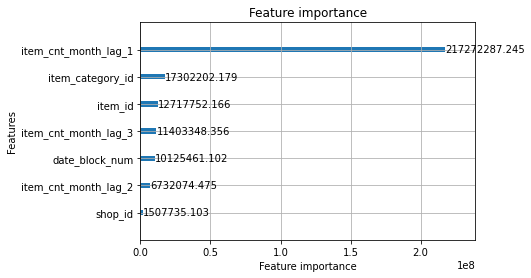

In [67]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

In [68]:
# submission
Y_test = model.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)